In [4]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [5]:
# Construct a 1-qubit bit-flip and phase-flip errors
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [6]:
# Compose two bit-flip and phase-flip errors
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9025, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


In [7]:
# Convert to Kraus operator
bit_flip_kraus = Kraus(bit_flip)
print(bit_flip_kraus)

Kraus([[[-9.74679434e-01+0.j,  0.00000000e+00+0.j],
        [ 0.00000000e+00+0.j, -9.74679434e-01+0.j]],

       [[ 0.00000000e+00+0.j,  2.23606798e-01+0.j],
        [ 2.23606798e-01+0.j, -4.96506831e-17+0.j]]],
      input_dims=(2,), output_dims=(2,))


In [8]:
# Convert to Superoperator
phase_flip_sop = SuperOp(phase_flip)
print(phase_flip_sop)

SuperOp([[1. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0.9+0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0.9+0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0. +0.j, 1. +0.j]],
        input_dims=(2,), output_dims=(2,))


In [9]:
# Convert back to a quantum error
print(QuantumError(bit_flip_kraus))

# Check conversion is equivalent to original error
QuantumError(bit_flip_kraus) == bit_flip

QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, Circuit = 
   ┌───────┐
q: ┤ kraus ├
   └───────┘


True

In [10]:
# Measurement miss-assignement probabilities
p0given1 = 0.1
p1given0 = 0.05

ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])

ReadoutError([[0.95 0.05]
 [0.1  0.9 ]])

## Adding errors to a Noise Model

#### 1. All-qubit quantum error

In [11]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3']


#### Specific qubit quantum error

In [12]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates on qubit 0 only
error = depolarizing_error(0.05, 1)
noise_model.add_quantum_error(error, ['u1', 'u2', 'u3'], [0])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'u2']
  Qubits with noise: [0]
  Specific qubit errors: [('u1', (0,)), ('u2', (0,)), ('u3', (0,))]


### Noise Model Examples

In [13]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


### Ideal Simulation

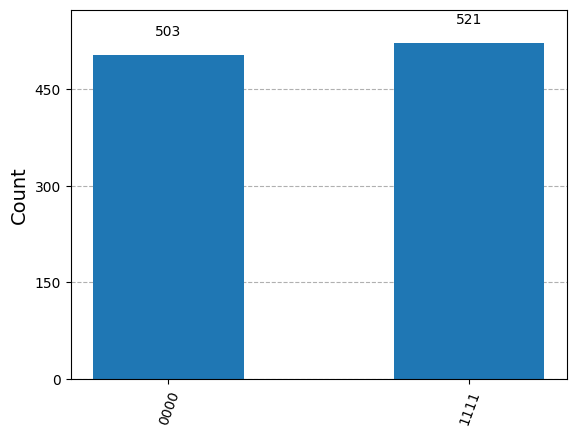

In [14]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

#### Noise Example 1: Basic bit-flip error noise model

In [15]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['measure', 'cx', 'u1', 'u3', 'reset', 'u2']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


#### Executing the noisy simulation

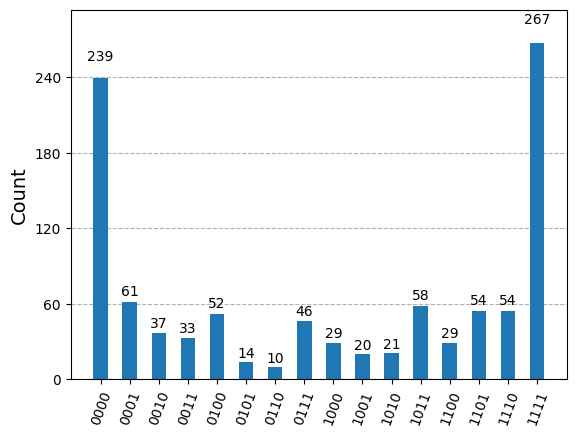

In [16]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

#### Noise Example 2: T1/T2 thermal relaxation

In [17]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['measure', 'cx', 'u3', 'reset', 'u2']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]


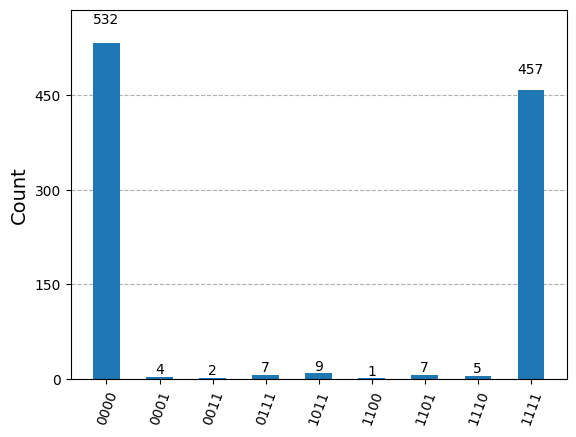

In [18]:
# Execute

# Run the noisy simulation
sim_thermal = AerSimulator(noise_model=noise_thermal)

# Transpile circuit for noisy basis gates
circ_tthermal = transpile(circ, sim_thermal)

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)

In [19]:
import qiskit
qiskit.__version__

'1.4.3'